In [1]:
import numpy as np
import pandas as pd
import io
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
run_data = """
2023-01-21, 2.98
2023-01-23, 3.02
2023-01-24, 5.07
2023-01-26, 5.52
2023-01-26, 5.52
2023-01-27, 6.46
2023-01-31, 5.11
2023-02-03, 5.59
2023-02-06, 9.28
2023-02-07, 5.07
2023-02-08, 3.99
"""

In [3]:
distance = 42.0
target = np.ceil(distance * 0.8)

start_date = datetime(2023, 1, 21)
end_date = datetime(2023, 4, 30)
target_end_date = end_date - timedelta(days=7)

def next_day(date, day):
    days = (day - date.weekday() + 7) % 7
    return date + timedelta(days=days)

start_sunday = next_day(start_date, 6)

number_of_weeks = int((target_end_date - start_sunday).days / 7)

In [4]:
list_data = []

for i in range(0, number_of_weeks + 1):
    list_data.append(
        {
            "date": (start_sunday + timedelta(days = 7 * i)).strftime("%Y-%m-%d"),
            "distance": np.ceil(i * target / number_of_weeks),
            "type": "target"
        }
    )
    
target_df = pd.DataFrame(list_data)    

In [5]:
run_df = pd.read_csv(io.StringIO(run_data), names=["date", "distance"])
run_df["type"] = "individual runs"

In [6]:
run_and_target_df = (
    pd.concat([target_df, run_df])
    .sort_values(["date"])
    .reset_index(drop=True)
)

In [7]:
run_and_target_df["training_day_number"] = (
    pd.to_datetime(run_and_target_df["date"], format="%Y-%m-%d") - start_date).dt.days

In [8]:
concat_df = pd.concat(
    [
        run_and_target_df,
        pd.DataFrame({
            "date": run_and_target_df.query("type == 'individual runs'")["date"],
            "distance": run_and_target_df.query("type == 'individual runs'")["distance"].cummax(),
            "type": "maximum run distance", 
            "training_day_number": run_and_target_df.query("type == 'individual runs'")["training_day_number"]
        })
    ], 
    axis=0
)

<ipython-input-11-875f99e89830>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


[Text(-20.0, 0, '01-01-23'),
 Text(0.0, 0, '21-01-23'),
 Text(20.0, 0, '10-02-23'),
 Text(40.0, 0, '02-03-23'),
 Text(60.0, 0, '22-03-23'),
 Text(80.0, 0, '11-04-23'),
 Text(100.0, 0, '01-05-23')]

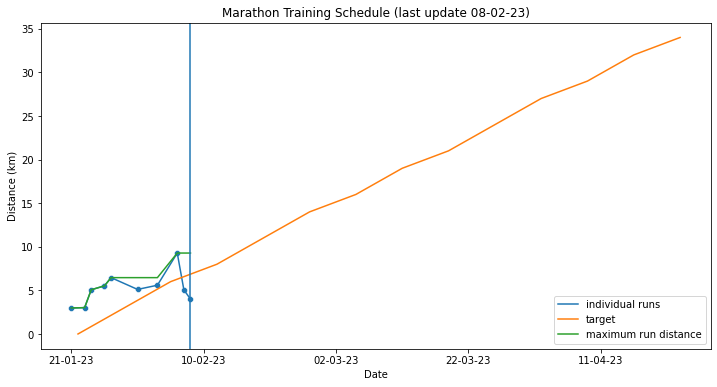

In [11]:
fig, ax = plt.subplots(figsize = (12,6)) 

p1 = sns.lineplot(x='training_day_number', 
                  y='distance',
                  hue='type', 
                  data=concat_df)

p2 = sns.scatterplot(data=concat_df.query("type == 'individual runs'"), 
                     x="training_day_number", 
                     y="distance")

# add vline at today
p1.axvline(int((datetime.today() - start_date).days), 0)

# set axis labels
ax.set(xlabel='Date', ylabel='Distance (km)', title=f"Marathon Training Schedule (last update {datetime.today().strftime('%d-%m-%y')})")

# get the xticks, which are the numeric location of the ticks
xticks = ax.get_xticks()
labels = [(start_date + timedelta(days=i)).strftime("%d-%m-%y") for i in xticks]

ax.set_xticklabels(labels)